## Imports

In [1]:
import os
import data_loading as dl
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import dtqn
import run_functions
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

2024-03-01 16:17:04.449892: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 16:17:04.487235: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 16:17:04.487268: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 16:17:04.488333: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 16:17:04.494298: I tensorflow/core/platform/cpu_feature_guar

AttributeError: module 'torch.nn' has no attribute 'Modu'

## Part 1: Loading the Experiment(s) Data
Based on the data retrieved from `data_analysis.ipynb`, get that data into a format capable of being used by a Machine Learning model.

<span style="color: orange;">**Future Experiment:** Generating multiple months or simply estimating a year in advance.</span>

In [2]:
MODEL_DATA_DIRECTORY = '../model_data/wheat_model_data/'
N_TREND_SAMPLES = 3 # Number of price samples for "history" trend (training data)
N_MONTHS_AHEAD = 1 # Number of months ahead to predict
TEST_SIZE = 0.2
OUTPUT_COLUMN_NAME = 'Price'

# Get the number of features for this model (given the model_data chosen)
sample_file_path = os.path.join(MODEL_DATA_DIRECTORY, os.listdir(MODEL_DATA_DIRECTORY)[0])
sample_columns = pd.read_csv(sample_file_path).columns[1:] # Skip 'Unnamed: 0' column
num_input_samples = len(sample_columns[2:-1]) + N_TREND_SAMPLES + 1 # +1 for 'n_previous_prices' later
print("Num Features: ", num_input_samples)

Num Features:  9


In [3]:
model_data = dl.get_model_data_from_directory(MODEL_DATA_DIRECTORY, sample_columns, N_TREND_SAMPLES)
model_data

/Users/sydneybalboni/Documents/GitHub/Predicting-Commodity-Food-Pricing/pytorch_conversion/data_loading.py:175: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_data = pd.concat([model_data, data_to_concat], ignore_index=True).drop(columns=['Unnamed: 0'])


,Date,Price,Proteus2,Food Price Index,Cereals Price Index,Wheat Futures,Harvest,Sentiment,n_previous_prices
0,2003-02-01,0.265824,0.557137,0.438166,0.397996,0.373617,0.451384,1.0,"[0.3472860213184801, 0.3067670698958382, 0.280..."
1,2003-03-01,0.250336,0.523654,0.405476,0.373497,0.340949,0.452166,1.0,"[0.3067670698958382, 0.2803532473597989, 0.265..."
2,2003-04-01,0.236095,0.487300,0.396399,0.367390,0.318326,0.452920,1.0,"[0.2803532473597989, 0.265823859939416, 0.2503..."
3,2003-05-01,0.230262,0.452831,0.405950,0.388607,0.343635,0.453537,1.0,"[0.265823859939416, 0.2503355702567417, 0.2360..."
4,2003-06-01,0.222138,0.417942,0.390506,0.376286,0.299917,0.454060,1.0,"[0.2503355702567417, 0.236095461763962, 0.2302..."
...,...,...,...,...,...,...,...,...,...
882,2016-08-01,0.446023,0.248252,0.541084,0.435392,0.428626,0.302668,1.0,"[0.429264668400003, 0.4328423870854326, 0.3831..."
883,2016-09-01,0.472188,0.232688,0.578410,0.417989,0.470033,0.283933,1.0,"[0.4328423870854326, 0.3831188765550763, 0.446..."
884,2016-10-01,0.528742,0.217955,0.596911,0.445031,0.513194,0.265419,1.0,"[0.3831188765550763, 0.4460234326875648, 0.472..."
885,2016-11-01,0.604214,0.203080,0.614585,0.457697,0.535438,0.245885,1.0,"[0.4460234326875648, 0.4721877893582922, 0.528..."


In [5]:
inputs_and_outputs = model_data.apply(dl.divide_inputs_and_outputs, axis=1)
inputs = inputs_and_outputs['inputs'].tolist(); outputs = inputs_and_outputs['output'].tolist()
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False) # Don't shuffle, should be cohesive samples not seen
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, scaler = dl.format_for_ML_usage_torch(inputs, outputs, num_input_samples)

print('x_train_tensor shape:', x_train_tensor.shape)
print('x_test_tensor shape:', x_test_tensor.shape)
print('y_train_tensor shape:', y_train_tensor.shape)
print('y_test_tensor shape:', y_test_tensor.shape)

x_train_tensor = torch.tensor(x_train_tensor, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_tensor, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_tensor, dtype=torch.float32)

train_data = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)


x_train_tensor shape: torch.Size([709, 9, 1])
x_test_tensor shape: torch.Size([178, 9, 1])
y_train_tensor shape: torch.Size([709, 1])
y_test_tensor shape: torch.Size([178, 1])


/var/folders/f2/v9wtlpyj2m32sw53dyky94mm0000gn/T/ipykernel_42869/1889222699.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_tensor = torch.tensor(x_train_tensor, dtype=torch.float32)
/var/folders/f2/v9wtlpyj2m32sw53dyky94mm0000gn/T/ipykernel_42869/1889222699.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
/var/folders/f2/v9wtlpyj2m32sw53dyky94mm0000gn/T/ipykernel_42869/1889222699.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test_tensor = torch.t

## Part 2: Building Complex ML Models

### Model 1: Simple, 1-Layer Transformer

In [6]:
# Model Architecture
HEAD_SIZE = 64
NUM_HEADS = 8
FF_DIM = 16

# ML Optimizer
LEARNING_RATE = 1e-3
CLIP_VALUE = 0.5 # Gradient Clipping (https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)
DROP_OUT_RATE = 0.2

d_model = NUM_HEADS
length = x_train_tensor.shape[1]  

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a long enough positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # Register as a buffer that is not a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x is [batch_size, seq_len, feature_size]
        # Adjust positional encoding to have the same size as the input
        pe = self.pe[:x.size(1), :]  # Shape: [seq_len, d_model]
        pe = pe.squeeze(1)  # Remove the singleton dimension
        # Ensure pe is expanded to match the batch size of x
        pe = pe.unsqueeze(0).repeat(x.size(0), 1, 1)  # Shape: [batch_size, seq_len, d_model]
        # The add operation below should now be valid
        return x + pe

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, head_size, num_heads, ff_dim, dropout=0):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout)
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=ff_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=ff_dim, out_channels=d_model, kernel_size=1)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        # Note: MultiheadAttention expects input of shape (L, N, E) where L is the sequence length, N is the batch size, and E is the embedding dimension.
        attn_output, _ = self.attention(query, key, value)
        out1 = self.layernorm1(query + attn_output)
        
        # Conv1D layers expect input of shape (N, C, L), hence we permute
        out1_permuted = out1.permute(1, 2, 0)
        ff_output = F.relu(self.conv1(out1_permuted))
        ff_output = self.conv2(ff_output)
        
        # Permute back to match the MultiheadAttention output shape
        ff_output = ff_output.permute(2, 0, 1)
        out2 = self.layernorm2(out1 + self.dropout(ff_output))
        
        return out2


In [9]:
class TransformerModel(nn.Module):
    def __init__(self, num_input_samples, d_model, head_size, num_heads, ff_dim, dropout=0, num_transformers=10):
        super(TransformerModel, self).__init__()  # Corrected super() call
        self.d_model = d_model
        self.input_projection = nn.Linear(1, d_model)
        self.pos_encoding = PositionalEncoding(d_model, num_input_samples)
        self.transformers = nn.ModuleList([
            TransformerBlock(d_model, head_size, num_heads, ff_dim, dropout) 
            for _ in range(num_transformers)
        ])
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_projection(x)  # Projects input to d_model dimensions
        x = x + self.pos_encoding(x)  # Apply positional encoding

        for transformer in self.transformers:
            x = transformer(x, x, x)  # Process through transformer blocks

        x = x.mean(dim=1, keepdim=True)  # Aggregate features
        x = self.output_layer(x)  # Apply the output layer to get the final prediction
        
        return x

In [10]:
# Define the model, loss function, and optimizer
model = TransformerModel(num_input_samples, d_model=d_model, head_size=HEAD_SIZE, num_heads=NUM_HEADS, ff_dim=FF_DIM, dropout=DROP_OUT_RATE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Part 3: Training the Model
This section is specifically for training the model built in the previous section. Some contants (`NUM_EPOCHS`, `BATCH_SIZE`) are provided and should be the only required parameters to adjust for this section of the experiment. 

A plot of the loss throughout the training process is provided for easy understanding about if the model is overfitting or underfitting. For a review of these concepts, see [this article](https://www.analyticsfordecisions.com/overfitting-and-underfitting/#:~:text=Overfitting%20happens%20when%20the%20model%20is%20too%20complex,poor%20performance%20on%20both%20training%20and%20test%20datasets.).
<br/><br/>
**Potential Future Parameters**
* **Regularization:** L1, L2, Dropout; helps prevent overfitting

In [11]:
# def learning_rate_scheduler(epoch, lr):
#     """
#     Learning rate scheduler
#     :param int epoch: current epoch
#     :param float lr: current learning rate
#     """
#     if epoch < 15:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
    
# callback = LearningRateScheduler(learning_rate_scheduler)

In [12]:
NUM_EPOCHS = 20
BATCH_SIZE = 3 # Fiscal Quarters

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
def train(model, data_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_loss = 0.
    for batch, (input, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = model(input)
        output = output.reshape(-1)
        target = target.reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Example data loading and training loop
# Assuming data_loader is defined and loads your dataset
train_loss = []
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    train_loss.append(train(model, train_loader, optimizer, criterion))
    print(f'| epoch {epoch:3d} | train_loss {train_loss[-1]:5.2f} |')


tensor([-0.8568, -0.8301, -0.8181], grad_fn=<ViewBackward0>) tensor([-0.2899, -0.3794, -0.4617])
tensor([-0.7224, -0.7748, -0.6917], grad_fn=<ViewBackward0>) tensor([-0.4954, -0.5423, -0.6018])
tensor([-0.6382, -0.6301, -0.5889], grad_fn=<ViewBackward0>) tensor([-0.5344, -0.6957, -0.7036])
tensor([-0.3995, -0.6067, -0.5813], grad_fn=<ViewBackward0>) tensor([ 0.0222,  0.0693, -0.5929])
tensor([-0.4994, -0.5169, -0.4803], grad_fn=<ViewBackward0>) tensor([-0.5473, -0.5728, -0.6267])
tensor([-0.4924, -0.4403, -0.4251], grad_fn=<ViewBackward0>) tensor([-0.6732, -0.7358, -0.8684])
tensor([-0.5528, -0.4877, -0.3960], grad_fn=<ViewBackward0>) tensor([-0.9995, -0.7981, -0.7845])
tensor([-0.5129, -0.5191, -0.5067], grad_fn=<ViewBackward0>) tensor([-0.7354, -0.7330, -0.7074])
tensor([-0.6077, -0.5144, -0.5533], grad_fn=<ViewBackward0>) tensor([-0.7803, -0.8637, -1.0044])
tensor([-0.6631, -0.6025, -0.5188], grad_fn=<ViewBackward0>) tensor([-0.9939, -0.9149, -1.0264])
tensor([-0.6894, -0.7080, -0.7

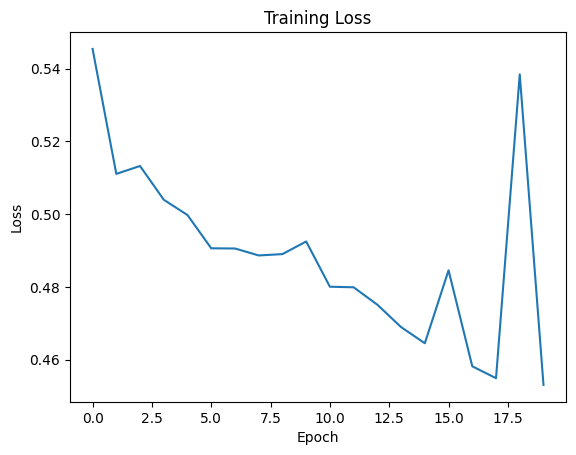

In [14]:
# Plot the loss over time
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Part 4: Examining Results
In this section, we're plotting the model's predictions versus the actual price point for the commodity in question. However, one plot focuses specifically on the testing data only (this is a better plot to see how well the model is performing/generalizing) and the other focuses on the entire dataset (this is a better plot to see if the model is correlating to the provided dataset at all).

Therefore, when **evaluating the performance** of the model, **the first plot should be used.** 

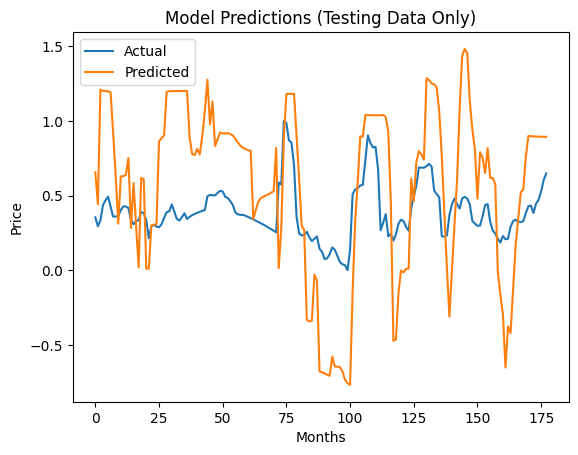

Mean Absolute Error (FINAL ACCURACY METRIC): 0.4383112916323832


In [15]:
# Ensure the model is in evaluation mode
from sklearn.metrics import mean_absolute_error


model.eval()

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    predictions = model(x_test_tensor)
    
predictions = predictions.reshape(-1)
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Model Predictions (Testing Data Only)')
plt.ylabel('Price')
plt.xlabel('Months')
plt.legend()
plt.show()

# Calculate the Mean Absolute Error
final_mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error (FINAL ACCURACY METRIC):', final_mae)

In [ ]:
# Save the model to saved_models
model.save(f'saved_models/wheat_price_transformer_model_{final_mae}.h5')

# DTQN